In [1]:
projectpath = "../"
import Pkg
Pkg.activate(projectpath)
#Pkg.develop(path=projectpath * "BackAction.jl")
Pkg.add(["DifferentialEquations", "LinearAlgebra", "Plots",
        "Distributed", "DelimitedFiles", "TOML", "Statistics", "Distributions"])
Pkg.instantiate()
Pkg.resolve()
using DifferentialEquations, LinearAlgebra, Distributed, Plots, DelimitedFiles, TOML, CSV, DataFrames, LaTeXStrings, 
        Statistics, Distributions
import BackAction.Utilities as util
import BackAction.MonitoringOperator as mo
import BackAction.CoreStructs as cs

  Activating project at `~/Documents/Research/MonitoringMetrology/notebooks`
   Resolving package versions...
  No Changes to `~/Documents/Research/MonitoringMetrology/notebooks/Project.toml`
  No Changes to `~/Documents/Research/MonitoringMetrology/notebooks/Manifest.toml`
  No Changes to `~/Documents/Research/MonitoringMetrology/notebooks/Project.toml`
  No Changes to `~/Documents/Research/MonitoringMetrology/notebooks/Manifest.toml`


In [2]:
include("Code/constants.jl");

In [3]:
k = 10
sampleexpval_x = readdlm("Ntimes1000/sampleexpvals_1_$(alphanorm_range[k])+0.0im.csv", ',',Float64) #$(l)_$(alphanorm_range[k])+0.0im")
sampleexpval_y = readdlm("Ntimes1000/sampleexpvals_2_$(alphanorm_range[k])+0.0im.csv", ',',Float64) #$(l)_$(alphanorm_range[k])+0.0im")
sampleexpval_z = readdlm("Ntimes1000/sampleexpvals_3_$(alphanorm_range[k])+0.0im.csv", ',',Float64) #$(l)_$(alphanorm_range[k])+0.0im")

mean_x = mean(sampleexpval_x, dims=2) 
mean_y = mean(sampleexpval_y, dims=2) 
mean_z = mean(sampleexpval_z, dims=2);

In [4]:
plot(tlist, sampleexpval_x[:, 1], label="sample", color="blue",title= L"\alpha=%$(alphanorm_range[k])", xlabel=L"t", ylabel=L"\langle\sigma\rangle")
plot!(tlist, sampleexpval_y[:, 1], label=false, color="blue")
plot!(tlist, sampleexpval_z[:, 1], label=false, color="blue")

plot!(tlist, mean_x, label="mean", color="red")
plot!(tlist, mean_y, label=false, color="red")
plot!(tlist, mean_z, label=false, color="red")


LoadError: Expects 10000 elements in each col of y, found 1000.

The first check is to look at the average of the homodynecurrent

In [5]:
dt = tf/cfg["ntimes"]

0.006314601233715484

In [6]:
using StatsBase

In [7]:
sample_current = ((0.5*cfg["GAMMA"]*(1.0 .+ sampleexpval_z) + sqrt(cfg["GAMMA"])*alphanorm_range[k]*sampleexpval_x))/alphanorm_range[k]; # no alpha^2


In [8]:
plot(tlist, sample_current[:, 1], label="sample", title="Current, alpha=$(alphanorm_range[k])", xlabel=L"t",
    ylabel=L"(\langle(\sqrt{\gamma}\sigma_++\alpha)(\sqrt{\gamma}\sigma_-+\alpha)\rangle - \alpha^2 )/\alpha")
plot!(tlist, mean(sample_current, dims=2), label="Mean")

LoadError: Expects 10000 elements in each col of y, found 1000.

next test is the autocorrelation. I fix $t=0$

In [9]:
Pkg.add("FFTW")
using FFTW

   Resolving package versions...
  No Changes to `~/Documents/Research/MonitoringMetrology/notebooks/Project.toml`
  No Changes to `~/Documents/Research/MonitoringMetrology/notebooks/Manifest.toml`


In [165]:
sample_currentchange = Array{Float64}(undef, cfg["ntimes"], cfg["ntraj"])
mean_current = dropdims(mean(sample_current, dims=2),dims=2)
dt = tf/cfg["ntimes"]
trange = collect(LinRange(0.0, tf, cfg["ntimes"]))
for k  in 1:cfg["ntraj"]
    sample_currentchange[:, k] .= sample_current[:, k] .- mean_current[:] 
end

freqs = fftfreq(cfg["ntimes"], cfg["ntimes"]/tf);
nfreqs = length(freqs)

sample_integrated_currentchange_ft = Array{ComplexF64}(undef, nfreqs, cfg["ntraj"])


for l in 1:cfg["ntraj"]
    for k in 1:nfreqs 
        for j in 1:cfg["ntimes"]
            sample_integrated_currentchange_ft[k, l] += sample_currentchange[j]*exp(1im*freqs[k]*trange[j])
        end
    end
end



In [166]:
sample_integrated_currentchange_ft .*= dt/sqrt(tf)

1000×1000 Matrix{ComplexF64}:
 -0.409702+9.63127e-319im  -0.409702+0.00405582im  …   -0.391172+0.0778399im
 -0.135161-0.456103im      -0.131339-0.452399im       -0.0493268-0.388994im
  0.460646-0.440403im       0.464303-0.43663im          0.524944-0.34012im
  0.846838+0.138105im       0.846047+0.137808im         0.907514+0.232356im
  0.615091+0.893191im       0.615245+0.892771im         0.612289+1.00515im
 -0.176267+1.26222im       -0.175705+1.26246im     …    0.073217+1.51534im
   -1.0454+0.922291im       -1.04427+0.923452im        -0.789449+1.17885im
  -1.42578+0.0389045im      -1.42463+0.0396577im        -1.16876+0.295618im
  -1.07552-0.856738im       -1.07564-0.857086im        -0.825471-0.600991im
 -0.230889-1.24656im       -0.230578-1.24564im         0.0253298-0.990791im
  0.589795-0.97303im        0.591047-0.972064im    …    0.844311-0.715867im
  0.964781-0.304224im       0.966123-0.302968im          1.21638-0.0626442im
  0.833045+0.315156im       0.834271+0.31633im           1.0

In [173]:
sample_power_spectrum = Array{Float64}(undef, nfreqs, cfg["ntraj"])
for l in 1:cfg["ntraj"]
    for k in 1:nfreqs
        sample_power_spectrum[k, l] =  abs(sample_integrated_currentchange_ft[k, l])^2
    end
end

In [174]:
power_spectrum = mean(sample_power_spectrum, dims=2)

1000×1 Matrix{Float64}:
 0.2025966161595167
 0.25641463890887867
 0.4389892977005558
 0.7646181192312185
 1.1738078914095251
 1.6333710281515177
 1.9707824024484442
 2.0758036389265393
 1.9445761768388925
 1.6593885182246688
 1.3391227110612187
 1.0562849943912882
 0.8191742731389442
 ⋮
 0.8241786130438256
 1.0542478947114886
 1.329740401116739
 1.6485315093524893
 1.9292528286771056
 2.0688197787667457
 1.9777335821158362
 1.6548685193422763
 1.2020160642755762
 0.7576314698432886
 0.4381568178693646
 0.25777548067119915

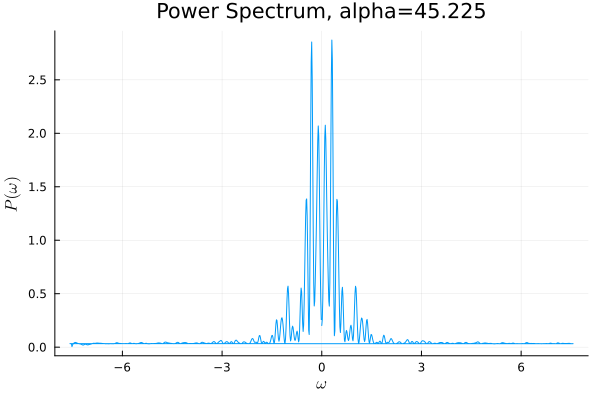

In [180]:
plot(freqs, power_spectrum, title="Power Spectrum, alpha=$(alphanorm_range[k])", xlabel=L"\omega", ylabel=L"P(\omega)", label=false)

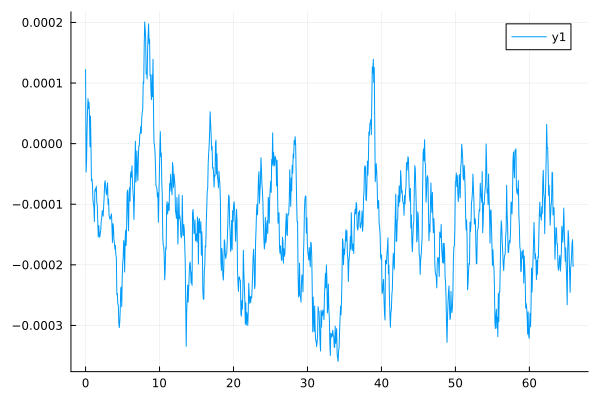

In [128]:
plot(tlist, mean_autocorrelation)

In [ ]:
# Calculate averages
expvalmean_x = Vector{Float64}(undef, cfg["ntimes"])
expvalmean_y = Vector{Float64}(undef, cfg["ntimes"])
expvalmean_z = Vector{Float64}(undef, cfg["ntimes"]);

In [27]:
# Begin by bringing here the data
l = 1
zvalue = 2.58
firatemean = Array{Float64}(undef, ndeltas, nalphas)
firateerr = Array{Float64}(undef, ndeltas, nalphas)
r = 0.0
for j in 1:nalphas
    r = alphanorm_range[j]
    sample = readdlm("Phi0.0/samplefi_$(r)_$(l)_$(nalphas).csv", ',', Float64)/tf;
    for k in 1:ndeltas
        firatemean[k, j] = mean(view(sample, :, k))
        firateerr[k, j] = 2.58*std(view(sample, :, k); mean = firatemean[k, j])/sqrt(cfg["ntraj"])
    end 
end 

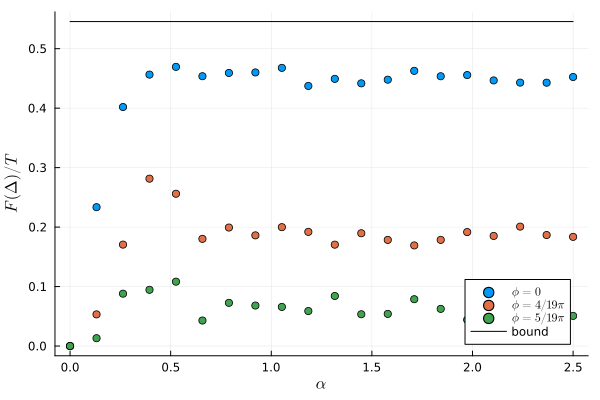

In [40]:
nalphas = 20
alphanorm_range = collect(LinRange(0.0, 2.5, nalphas))
alphaphase_range = collect(LinRange(0.0, 2 * pi, nalphas))

j = 1
scatter(alphanorm_range, Vector(df00[j, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\phi=0")
j = 5
scatter!(alphanorm_range, Vector(df00[j, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\phi=%$(j-1)/19 \pi")
j = 6
scatter!(alphanorm_range, Vector(df00[j, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\phi=%$(j-1)/19 \pi")

boundvalue = -4*obtain_secondderivative(0.0, params, tspan)/tf
plot!(alphanorm_range, boundvalue*ones(nalphas), color="black", label="bound")

In [17]:
function generate_generalized_lme(delta1, delta2)
    function _generalized_lme!(dr, r, p, t)
   dr[1] = 0.5*1im*OMEGA*r[2] -0.5*1im*OMEGA*r[3] + GAMMA*r[4]
   dr[2] = 0.5*1im*OMEGA*r[1] +(1im*delta1-0.5*GAMMA)*r[2] -0.5im* OMEGA*r[4]
   dr[3] = -0.5*1im*OMEGA*r[1] +(-1im*delta2-0.5*GAMMA)*r[3] +0.5im* OMEGA*r[4]
   dr[4] = -0.5*1im*OMEGA*r[2] +0.5*1im*OMEGA*r[3] +(1im*delta1-1im*delta2-GAMMA)*r[4]
    end 
    return _generalized_lme!
end 

function obtain_fidelity(delta1, delta2, params, tspan)
    f! = generate_generalized_lme(delta1, delta2)
    u0 = [params.psi0[1]*conj(params.psi0[1]), 
        params.psi0[1]*conj(params.psi0[2]),
        params.psi0[2]*conj(params.psi0[1]),
        params.psi0[2]*conj(params.psi0[2])]
    prob = ODEProblem(f!, u0, tspan; save_everystep=false, save_idxs=[1, 4], save_end=true)
    sol = solve(prob)
    return abs(sol.u[end][1] + sol.u[end][2])
end

function obtain_secondderivative(delta, params, tspan)
    h = delta*1e-3 +1e-4 
    return (obtain_fidelity(delta, delta + h, params, tspan) - 
            2*obtain_fidelity(delta, delta, params, tspan) +
            obtain_fidelity(delta, delta - h, params, tspan))/h^2
end

obtain_secondderivative (generic function with 1 method)

In [18]:
mudata = Vector{Float64}(undef, ndeltas)
for k in 1:ndeltas
    mudata[k] = -4*obtain_secondderivative(delta_range[k], params, tspan)/tf
end 

In [21]:
using Printf
#@sprintf("%.2f",alpha_range[1])

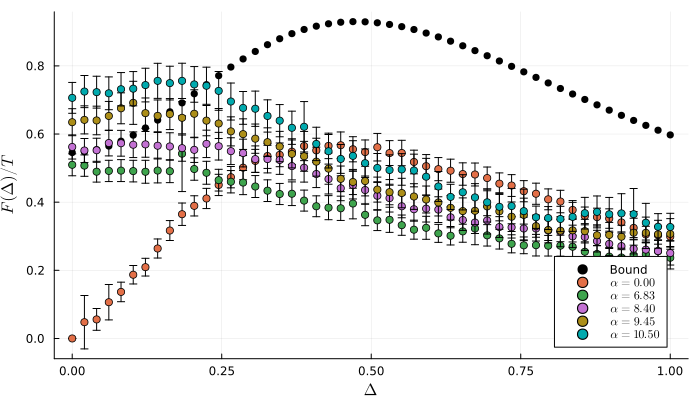

In [47]:
scatter(delta_range, mudata, color="black", label="Bound", xlabel=L"\Delta", ylabel=L"F(\Delta)/T",size=(700, 400), legend=true)

k = 1
alphaval = @sprintf("%.2f", alphanorm_range[k])
scatter!(delta_range, firatemean[:, k],  label=L" \alpha=%$(alphaval)", yerror=firateerr[:, k])

k = 14
alphaval = @sprintf("%.2f", alphanorm_range[k])
scatter!(delta_range, firatemean[:, k],  label=L" \alpha=%$(alphaval)", yerror=firateerr[:, k])

#k = 15
#alphaval = @sprintf("%.2f", alphanorm_range[k])
#scatter!(delta_range, firatemean[:, k],  label=L" \alpha=%$(alphaval)", yerror=firateerr[:, k])
#
#k = 16
#alphaval = @sprintf("%.2f", alphanorm_range[k])
#scatter!(delta_range, firatemean[:, k],  label=L" \alpha=%$(alphaval)", yerror=firateerr[:, k])
#
k = 17
alphaval = @sprintf("%.2f", alphanorm_range[k])
scatter!(delta_range, firatemean[:, k],  label=L" \alpha=%$(alphaval)", yerror=firateerr[:, k])

k = 19
alphaval = @sprintf("%.2f", alphanorm_range[k])
scatter!(delta_range, firatemean[:, k],  label=L" \alpha=%$(alphaval)", yerror=firateerr[:, k])

k = 21
alphaval = @sprintf("%.2f", alphanorm_range[k])
scatter!(delta_range, firatemean[:, k],  label=L" \alpha=%$(alphaval)", yerror=firateerr[:, k])


In [48]:
cfg["nworkers"]

20

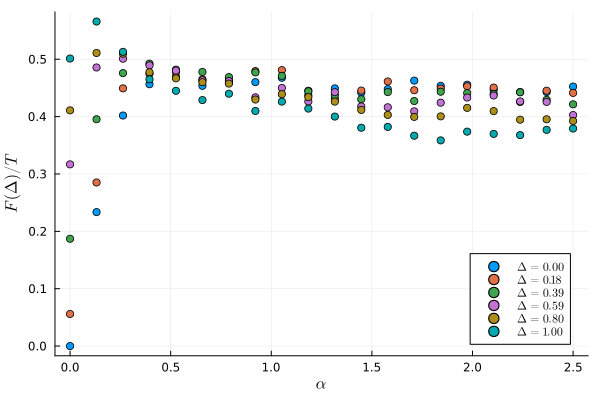

In [166]:
deltavalue = @sprintf("%.2f",delta_range[1])
scatter(alpha_range, Vector(datafi[1, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\Delta=%$(deltavalue)")

deltavalue = @sprintf("%.2f",delta_range[10])
scatter!(alpha_range, Vector(datafi[3, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\Delta=%$(deltavalue)")

deltavalue = @sprintf("%.2f",delta_range[20])
scatter!(alpha_range, Vector(datafi[6, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\Delta=%$(deltavalue)")

deltavalue = @sprintf("%.2f",delta_range[30])
scatter!(alpha_range, Vector(datafi[9, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\Delta=%$(deltavalue)")


deltavalue = @sprintf("%.2f",delta_range[40])
scatter!(alpha_range, Vector(datafi[12, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\Delta=%$(deltavalue)")

deltavalue = @sprintf("%.2f",delta_range[50])
scatter!(alpha_range, Vector(datafi[15, :]), xlabel=L"\alpha", ylabel=L"F(\Delta)/T", label=L"\Delta=%$(deltavalue)")



In [158]:
nalphas

20

# FI Analysis

In [29]:
filename = "Ntimes1000/samplefi_35.175+0.0im.csv"
fisample = readdlm(filename, ',', Float64)./tf;

In [30]:
mean(fisample)

1551.836227284624